In [1]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import re
from scipy import signal
from scipy.signal import find_peaks
plt.rcParams['pdf.fonttype'] = 42

In [2]:
cmap = sns.color_palette()
cmap_hm = "plasma"

data_tot_hm = pd.read_csv("./_total_time-course.csv", index_col=0)
data_div_to_div = pd.read_csv("./_div_to_div.csv", index_col=0)
data_stats = pd.read_csv("./_stats.csv", index_col=0)

strains_to_omit = ["HS188"]

strains = sorted(data_tot_hm["strain"].unique().tolist())  # strainを重複なく抜き出す
for cmp in strains_to_omit:
    if cmp in strains:
        strains.remove(cmp)     # plotに使いたくないやつを除く

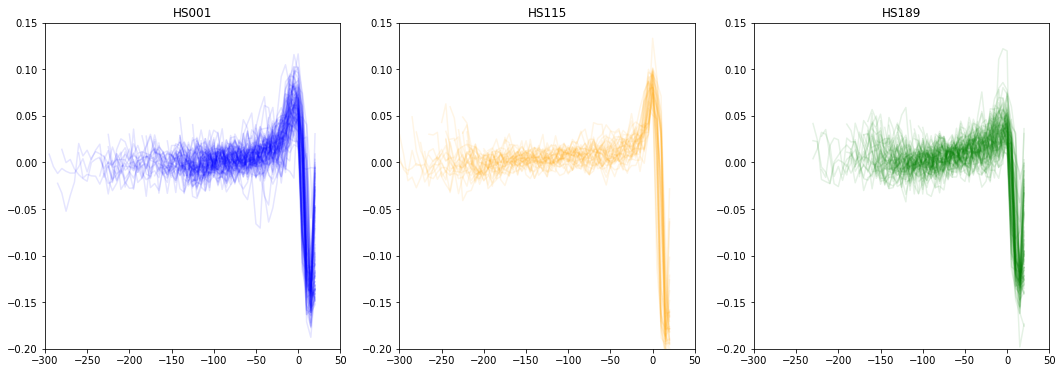

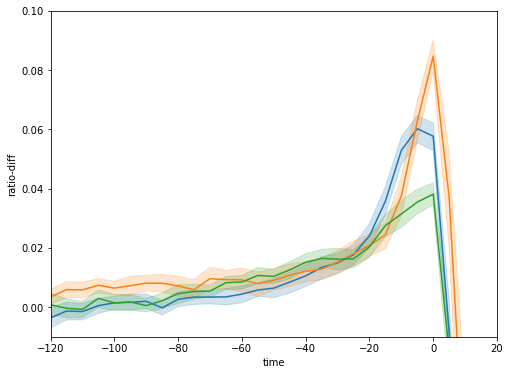

In [3]:
df_plot_al = pd.DataFrame({})
window = 3 # 移動平均の範囲
w = np.ones(window)/window

color = ["blue", "orange", "green"]
fig1, axes = plt.subplots(1, 3, figsize=(18, 6))
for k in range(len(strains)):
    strain = strains[k]
    data_temp = data_div_to_div.loc[(data_div_to_div["strain"] == strain), ["time", "CDKEV-raw", "id"]]

    cells = sorted(data_temp["id"].unique().tolist())  # cellを重複なく抜き出す
    for cell in cells:
        df_CDK = [x for x in data_temp.loc[data_temp["id"] == cell]["CDKEV-raw"]]
        peaks, _ = find_peaks(df_CDK, height=1.7, distance=20)
        peaks = [int(x) for x in peaks]
        CDK_peaks = [df_CDK[x] for x in peaks]
        if len(CDK_peaks) != 2:
            continue
        align_idx = peaks[-1]
        start_idx = peaks[0] + 4 # 分裂の20分後から取る
        time = [(i - align_idx) * 5 for i in range(len(df_CDK))][start_idx:]
        df_CDK = df_CDK[start_idx:]
        df_CDK_sm = np.convolve(df_CDK, w, mode='valid')

        df_cdk_diff = [df_CDK_sm[i+1] - df_CDK_sm[i] for i in range(len(df_CDK_sm)-1)]
        
        axes[k].plot(time[3:], df_cdk_diff, color=color[k], alpha=0.1)

        temp = pd.DataFrame([time[3:], df_cdk_diff, [strain for x in range(len(df_cdk_diff))], [cell for x in range(len(df_cdk_diff))]], index=["time", "ratio-diff", "strain", "id"])
        df_plot_al = pd.concat([df_plot_al, temp.T], ignore_index=True)
        
    axes[k].set_xlim(-300, 50)
    axes[k].set_ylim(-0.2, 0.15)
    axes[k].set_title(strain)
plt.savefig("./__results_separated_diff.png")
plt.savefig("./__results_separated_diff.pdf")

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.lineplot(x="time", y="ratio-diff", data=df_plot_al, hue="strain", ci=95, legend=False, ax=ax)
#ax.set_xlim(-300, 50)
ax.set_ylim(-0.01, 0.10)
ax.set_xlim(-120, 20)
plt.savefig("./__results_ave_diff.png")
plt.savefig("./__results_ave_diff.pdf")



85
44
89
strain
HS001    1.952484
HS115    2.076319
HS189    1.929904
Name: cdk-at-div, dtype: float64 strain
HS001    0.075147
HS115    0.035596
HS189    0.055181
Name: cdk-at-div, dtype: float64
strain
HS001    189.529412
HS115    288.409091
HS189    176.179775
Name: cell-cycle-length, dtype: float64 strain
HS001    45.451593
HS115    54.791070
HS189    35.834392
Name: cell-cycle-length, dtype: float64


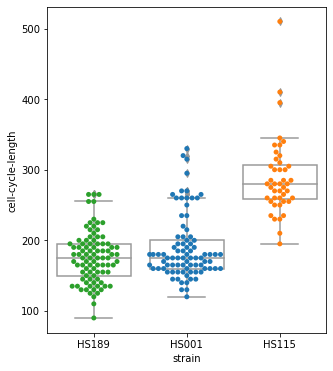

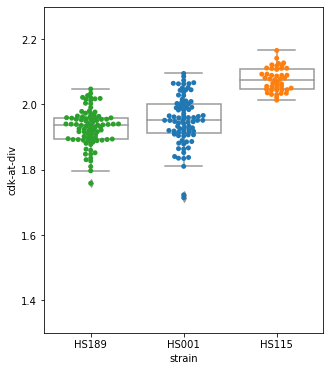

In [11]:
# 分裂時間の分布に関するプロットを作る
fig = plt.figure(figsize=(5, 6))
data_temp = data_stats.copy()
for strain_to_omit in strains_to_omit:
    data_temp = data_temp.loc[data_temp["strain"] != strain_to_omit]
sns.boxplot(x="strain", y="cell-cycle-length", data=data_temp, color="white", order=["HS189", "HS001", "HS115"])
sns.swarmplot(x="strain", y="cell-cycle-length", data=data_temp, hue="strain", order=["HS189", "HS001", "HS115"])
plt.legend([], [], frameon=False)
plt.savefig("./__cycle-length_distribution.png")
plt.savefig("./__cycle-length_distribution.pdf")
print(len(data_temp.loc[data_temp["strain"]=="HS001"]))
print(len(data_temp.loc[data_temp["strain"]=="HS115"]))
print(len(data_temp.loc[data_temp["strain"]=="HS189"]))

fig = plt.figure(figsize=(5, 6))
data_temp = data_stats.copy()
for strain_to_omit in strains_to_omit:
    data_temp = data_temp.loc[data_temp["strain"] != strain_to_omit]
sns.boxplot(x="strain", y="cdk-at-div", data=data_temp, color="white", order=["HS189", "HS001", "HS115"])
sns.swarmplot(x="strain", y="cdk-at-div", data=data_temp, hue="strain", order=["HS189", "HS001", "HS115"])
plt.legend([], [], frameon=False)
plt.ylim(1.3, 2.3)
plt.savefig("./__cdk_distribution2.png")
plt.savefig("./__cdk_distribution2.pdf")
print(data_temp.groupby("strain").mean()["cdk-at-div"], data_temp.groupby("strain").std()["cdk-at-div"])
print(data_temp.groupby("strain").mean()["cell-cycle-length"], data_temp.groupby("strain").std()["cell-cycle-length"])
